In [1]:
from satpy import Scene, find_files_and_readers
from pyresample import create_area_def
from satpy.writers import get_enhanced_image
from datetime import datetime
import math

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from glob import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from satpy import MultiScene
from satpy.multiscene import timeseries

%matplotlib inline
import cmocean
import cmocean.cm as cmo

from dask.diagnostics import ProgressBar
from celluloid import Camera
from IPython.display import HTML

In [2]:
# Generates a list of file names
filenames = glob('../../SAT_DATA/HDF/MODIS_AQUA_APR-2_APR-22_2022_HDF_L1\\MYD021KM.A20221*.hdf')
filenames.sort()
filenames

[]

In [3]:
# ORGANIZE IT ALL DAY THE DAY 
swats = np.unique([f.split('.')[5] for f in filenames])
swats

array([], dtype=float64)

In [4]:
## CREATE THE BADE 
i=0
base = '../../SAT_DATA/HDF/MODIS_AQUA_APR-2_APR-22_2022_HDF_L1\\MYD021KM.'
dayfiles = glob(base+swats[1]+'*')
print(dayfiles)
#CREATE SCENE 
scn = Scene(dayfiles, reader='modis_l1b')
#LOOK AT THE KEYS 
scn.load(scn.available_dataset_names())
scn.keys()

IndexError: index 1 is out of bounds for axis 0 with size 0

In [5]:
# TEST THAT ALL IS GOOD WITH A TRUE COLOR IMAGE
i=0
dayfiles = glob(base+swats[i]+'*')
print(dayfiles)
#create scene
scn = Scene(dayfiles, reader='modis_l1b')
scn.load(['10','4'])
scn.load(['true_color'])
#reprpject
my_area = create_area_def('my_area', {'proj': 'lcc', 'lon_0': -91., 'lat_0': 29.5, 'lat_1': 29.5, 'lat_2': 29.5},
                          width=1500, height=750,
                          area_extent=[-94, 27.5, -88, 30.5], units='degrees')
new_scn = scn.resample(my_area)
#generate RGB from true color
rgb = get_enhanced_image(new_scn['true_color'])

#extract projection and lon lat from products
crs = new_scn['true_color'].attrs['area'].to_cartopy_crs()

fig =  plt.figure(figsize=(6, 4), dpi=400)
ax1 = plt.subplot(projection=crs)
rgb.data.plot.imshow(rgb='bands', transform=crs, ax=ax1)
ax1.set_title('MODISA_Mdelta_%s' % new_scn.start_time.isoformat())
#fig.savefig('MODISA_Mdelta_%s_rgb.png' % new_scn.start_time.isoformat())

IndexError: index 0 is out of bounds for axis 0 with size 0

['../../SAT_DATA/HDF/MODIS_AQUA_APR-2_APR-22_2022_HDF_L1\\MYD021KM.A2022107.1855.061.2022108230711.hdf']


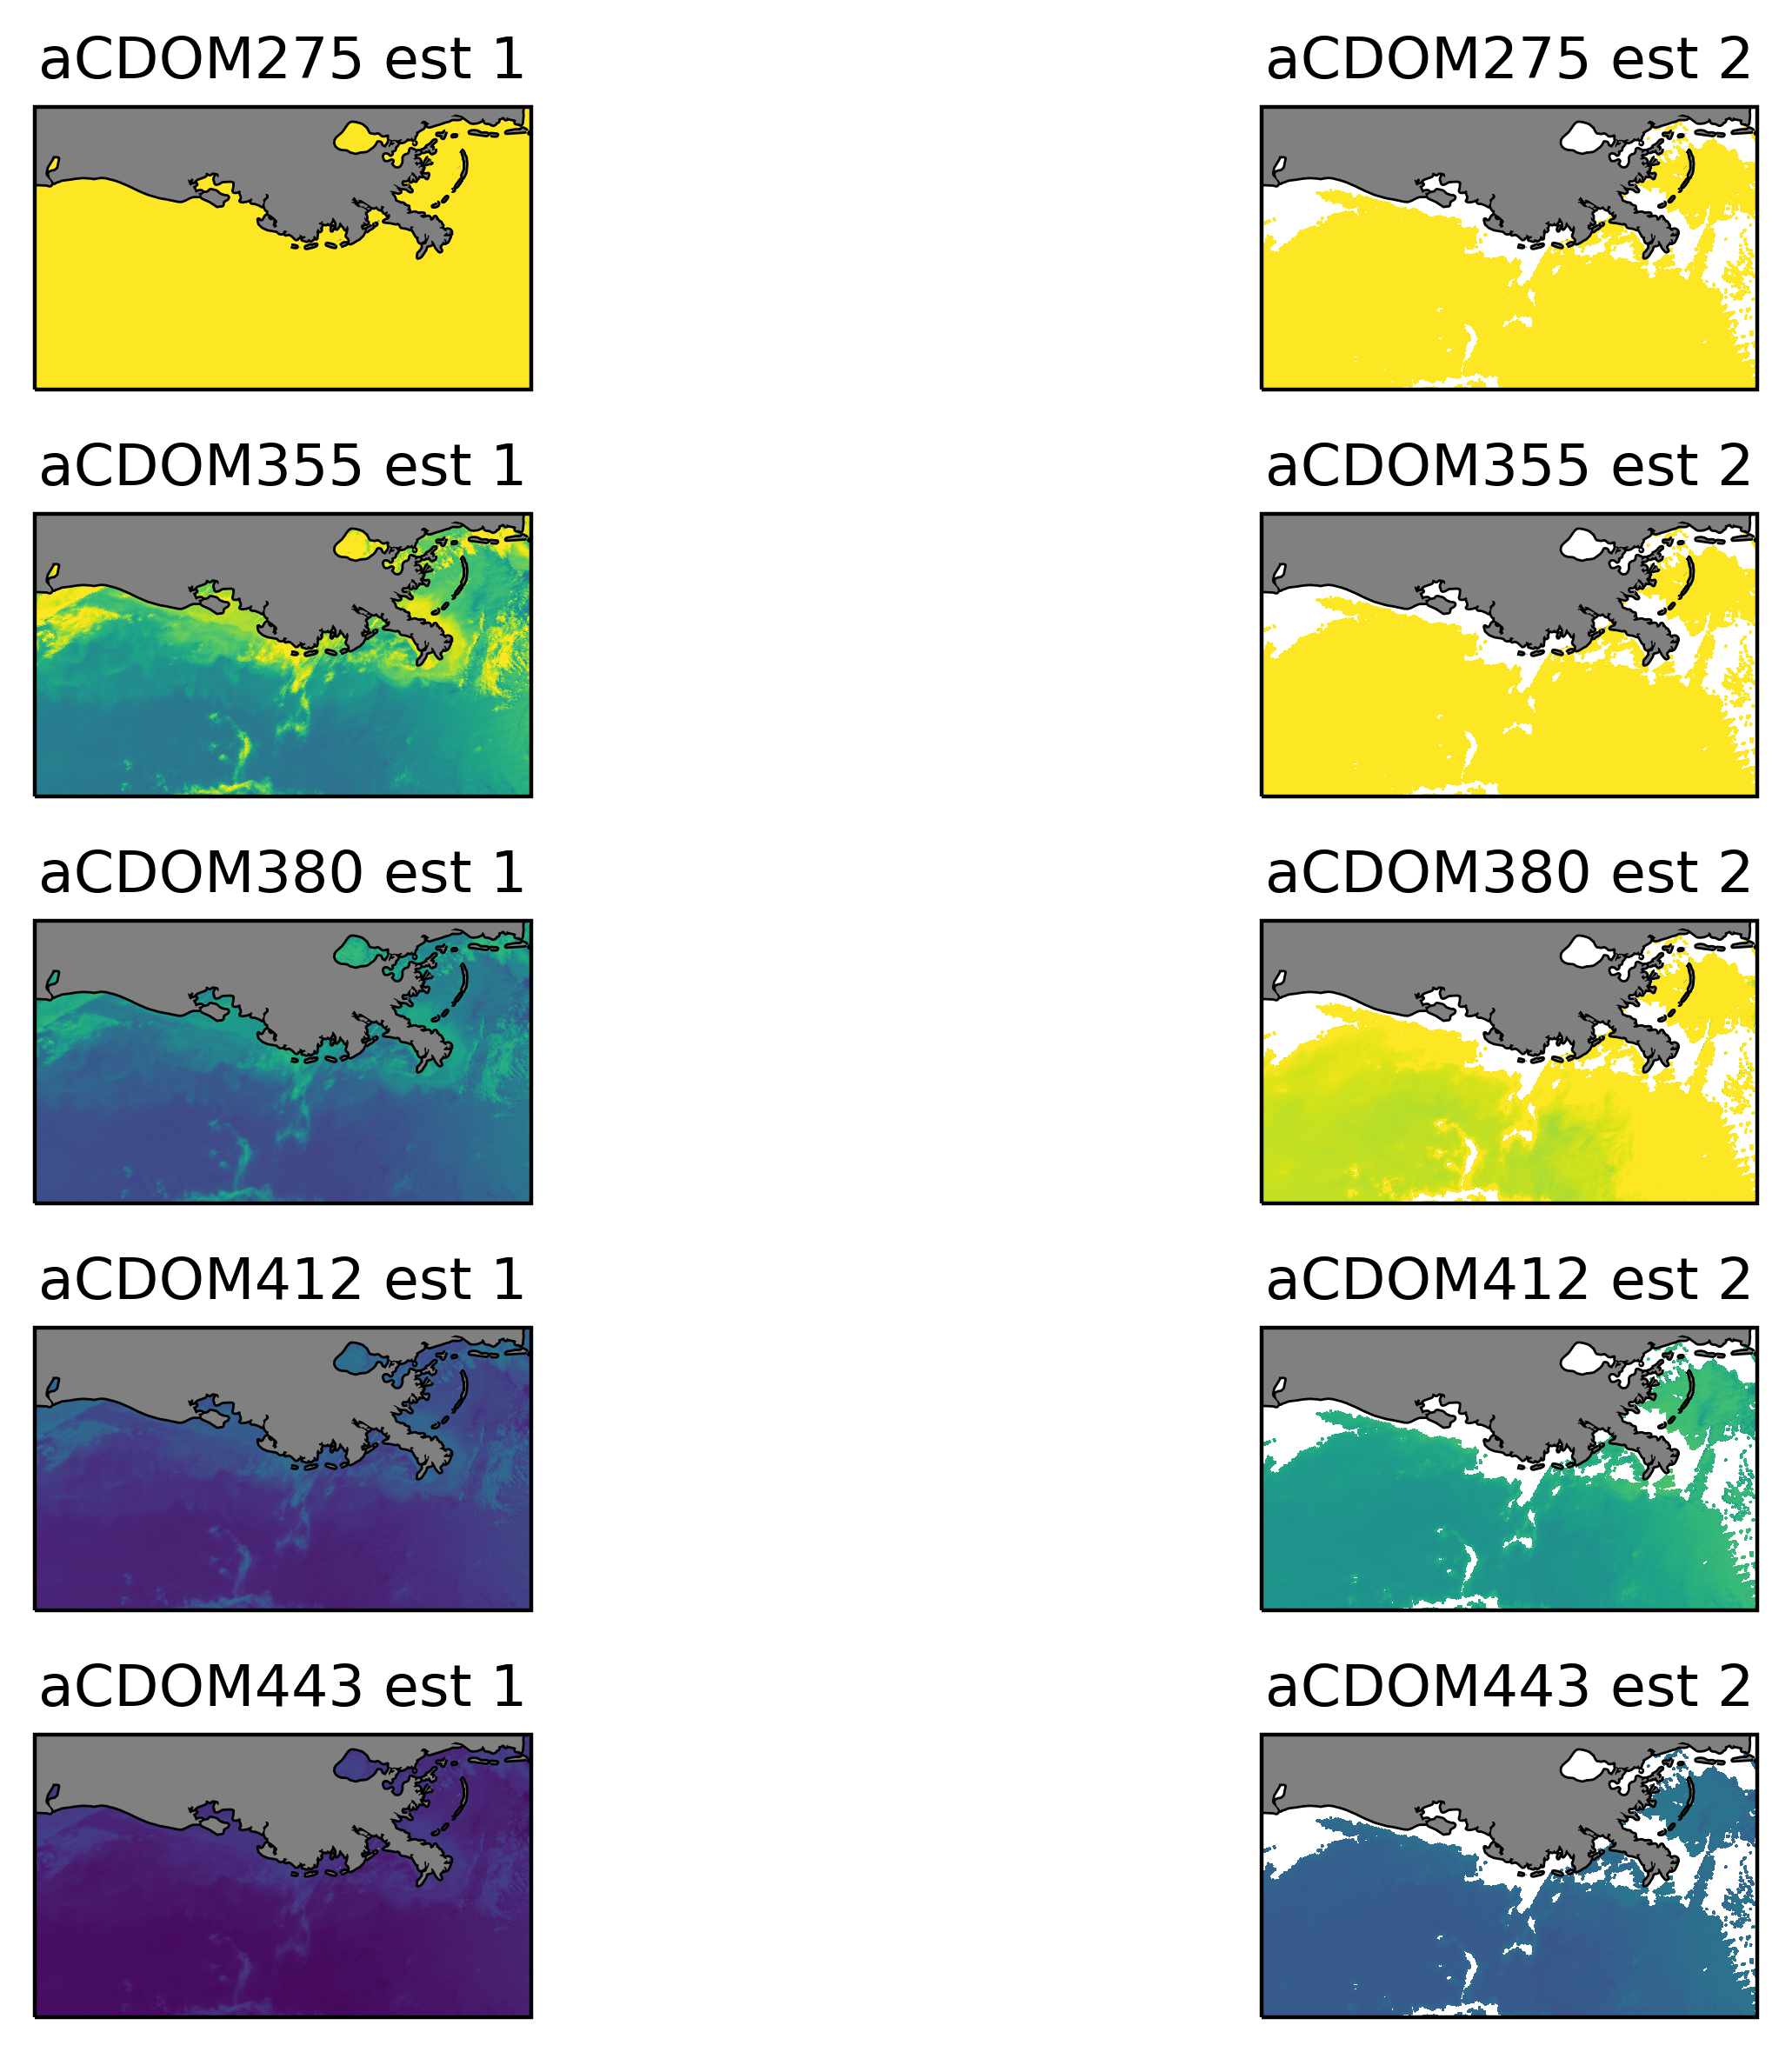

In [6]:
#HERE WE CALCUTE CDOM WITH THE ALGORITHUM WITH 
#Mannino et al. 2015
i=0
dayfiles = glob(base+swats[i]+'*')
print(dayfiles)
extent=[-94, 27.5, -88, 30.5]
res = '10m'

#load scene
scn = Scene(dayfiles, reader='modis_l1b')
scn.load(['8','4','13lo'])
scn.load(['true_color'])

#reproject
my_area = create_area_def('my_area', {'proj': 'lcc', 'lon_0': -91., 'lat_0': 29.5, 'lat_1': 29.5, 'lat_2': 29.5},
                          width=1500, height=750,
                          area_extent=extent, units='degrees')
new_scn = scn.resample(my_area)

#generate RGB from true color
rgb = get_enhanced_image(new_scn['true_color'])

#extract projection
crs = new_scn['true_color'].attrs['area'].to_cartopy_crs()

#calculate aCDOM 412
Rss412 = (new_scn['8'])
Rss555 = (new_scn['4'])
Rss667 = (new_scn['13lo'])

B0 = 0.2581; B1 = 1.583; B2 = 24.87
aCDOM275_a = (np.log((Rss412/Rss555 - B0)/ B2))/(-B1)
aCDOM275_a = aCDOM275_a.compute()

B0 = 0.2452; B1 = 5.576; B2 = 4.838
aCDOM355_a = (np.log((Rss412/Rss555 - B0)/ B2))/(-B1)
aCDOM355_a = aCDOM355_a.compute()

B0 = 0.2492; B1 = 8.689; B2 = 4.608
aCDOM380_a = (np.log((Rss412/Rss555 - B0)/ B2))/(-B1)
aCDOM380_a = aCDOM380_a.compute()

B0 = 0.2487; B1 = 14.028; B2 = 4.085
aCDOM412_a = (np.log((Rss412/Rss555 - B0)/ B2))/(-B1)
aCDOM412_a = aCDOM412_a.compute()

B0 = 0.2479; B1 = 23.40; B2 = 3.770
aCDOM443_a = (np.log((Rss412/Rss555 - B0)/ B2))/(-B1)
aCDOM443_a = aCDOM443_a.compute()

B0 = 0.9925; B1 = 2.054; B2 = 634.2
aCDOM275_b = (np.log((Rss412/Rss667 - B0)/ B2))/(-B1)
aCDOM275_b = aCDOM275_b.compute()

B0 = 0.8569; B1 = 7.661; B2 = 91.97
aCDOM355_b = (np.log((Rss412/Rss667 - B0)/ B2))/(-B1)
aCDOM355_b = aCDOM355_b.compute()

B0 = 0.865; B1 = 11.55; B2 = 79.16
aCDOM380_b = (np.log((Rss412/Rss667 - B0)/ B2))/(-B1)
aCDOM380_b = aCDOM380_b.compute()

B0 = 0.8625; B1 = 18.44; B2 = 62.89
aCDOM412_b = (np.log((Rss412/Rss667 - B0)/ B2))/(-B1)
aCDOM412_b = aCDOM412_b.compute()

B0 = 0.8502; B1 = 30.53; B2 = 54.78
aCDOM443_b = (np.log((Rss412/Rss667 - B0)/ B2))/(-B1)
aCDOM443_b = aCDOM443_b.compute()

#extract projection and lon lat from products
crs = new_scn['true_color'].attrs['area'].to_cartopy_crs()
lons, lats = new_scn['true_color'].attrs['area'].get_lonlats()

#set up figure size and resolution
fig =  plt.figure(figsize=(9, 6), dpi=400)

# aCDOM275_a 
trim = aCDOM275_a.max().values
ax3 = plt.subplot(5, 2, 1, projection=crs)
ax3.coastlines(res)
ax3.pcolormesh(lons, lats, aCDOM275_a.where(aCDOM275_a<=trim), transform=ccrs.PlateCarree(),
              vmin=.01, vmax=.3)
ax3.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                            name='land', facecolor='grey',
                                            scale=res))
ax3.set_title('aCDOM275 est 1')

# aCDOM275_b
trim = aCDOM275_b.max().values
ax4 = plt.subplot(5, 2, 2, projection=crs)
ax4.coastlines(res)
ax4.pcolormesh(lons, lats, aCDOM275_b.where(aCDOM275_b<=trim), transform=ccrs.PlateCarree(),
              vmin=.01, vmax=.3)
ax4.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                            name='land', facecolor='grey',
                                            scale=res))
ax4.set_title('aCDOM275 est 2')

# aCDOM355_a 
trim = aCDOM355_a.max().values
ax5 = plt.subplot(5, 2, 3, projection=crs)
ax5.coastlines(res)
ax5.pcolormesh(lons, lats, aCDOM355_a.where(aCDOM355_a<=trim), transform=ccrs.PlateCarree(),
              vmin=.01, vmax=.3)
ax5.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                            name='land', facecolor='grey',
                                            scale=res))
ax5.set_title('aCDOM355 est 1')

# aCDOM355_b 
trim = aCDOM355_b.max().values
ax6 = plt.subplot(5, 2, 4, projection=crs)
ax6.coastlines(res)
ax6.pcolormesh(lons, lats, aCDOM355_b.where(aCDOM355_b<=trim), transform=ccrs.PlateCarree(),
              vmin=.01, vmax=.3)
ax6.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                            name='land', facecolor='grey',
                                            scale=res))
ax6.set_title('aCDOM355 est 2')

# aCDOM380_a 
trim = aCDOM380_a.max().values
ax7 = plt.subplot(5, 2, 5, projection=crs)
ax7.coastlines(res)
ax7.pcolormesh(lons, lats, aCDOM380_a.where(aCDOM380_a<=trim), transform=ccrs.PlateCarree(),
              vmin=.01, vmax=.3)
ax7.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                            name='land', facecolor='grey',
                                            scale=res))
ax7.set_title('aCDOM380 est 1')

# aCDOM380_b 
trim = aCDOM380_b.max().values
ax8 = plt.subplot(5, 2, 6, projection=crs)
ax8.coastlines(res)
ax8.pcolormesh(lons, lats, aCDOM380_b.where(aCDOM380_b<=trim), transform=ccrs.PlateCarree(),
              vmin=.01, vmax=.3)
ax8.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                            name='land', facecolor='grey',
                                            scale=res))
ax8.set_title('aCDOM380 est 2')

#  aCDOM412_a
trim = aCDOM412_a.max().values
ax9 = plt.subplot(5, 2, 7, projection=crs)
ax9.coastlines(res)
ax9.pcolormesh(lons, lats, aCDOM412_a.where(aCDOM412_a<=trim), transform=ccrs.PlateCarree(),
              vmin=.01, vmax=.3)
ax9.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                            name='land', facecolor='grey',
                                            scale=res))
ax9.set_title('aCDOM412 est 1')

# aCDOM412_b 
trim = aCDOM412_b.max().values
ax10 = plt.subplot(5, 2, 8, projection=crs)
ax10.coastlines(res)
ax10.pcolormesh(lons, lats, aCDOM412_b.where(aCDOM412_b<=trim), transform=ccrs.PlateCarree(),
              vmin=.01, vmax=.3)
ax10.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                            name='land', facecolor='grey',
                                            scale=res))
ax10.set_title('aCDOM412 est 2')

# aCDOM443_a 
trim = aCDOM443_a.max().values
ax11 = plt.subplot(5, 2, 9, projection=crs)
ax11.coastlines(res)
ax11.pcolormesh(lons, lats, aCDOM443_a.where(aCDOM443_a<=trim), transform=ccrs.PlateCarree(),
              vmin=.01, vmax=.3)
ax11.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                            name='land', facecolor='grey',
                                            scale=res))
ax11.set_title('aCDOM443 est 1')

# aCDOM443_b 
trim = aCDOM443_b.max().values
ax12 = plt.subplot(5, 2, 10, projection=crs)
ax12.coastlines(res)
ax12.pcolormesh(lons, lats, aCDOM443_b.where(aCDOM443_b<=trim), transform=ccrs.PlateCarree(),
              vmin=.01, vmax=.3)
ax12.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                            name='land', facecolor='grey',
                                            scale=res))
ax12.set_title('aCDOM443 est 2')
fig.tight_layout()

#fig.savefig('../outputs/Mannino.png')

['../../SAT_DATA/HDF/MODIS_AQUA_APR-2_APR-22_2022_HDF_L1\\MYD021KM.A2022107.1855.061.2022108230711.hdf']


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\satpy\modifiers\angles.py:407: RuntimeWarning: invalid value encountered in log
  grad_factor = 1. - np.log(grad_factor + 1) / np.log(2)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in arccos
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\satpy\modifiers\angles.py:407: RuntimeWarning: invalid value encountered in log
  grad_factor = 1. - np.log(grad_factor + 1) / np.log(2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


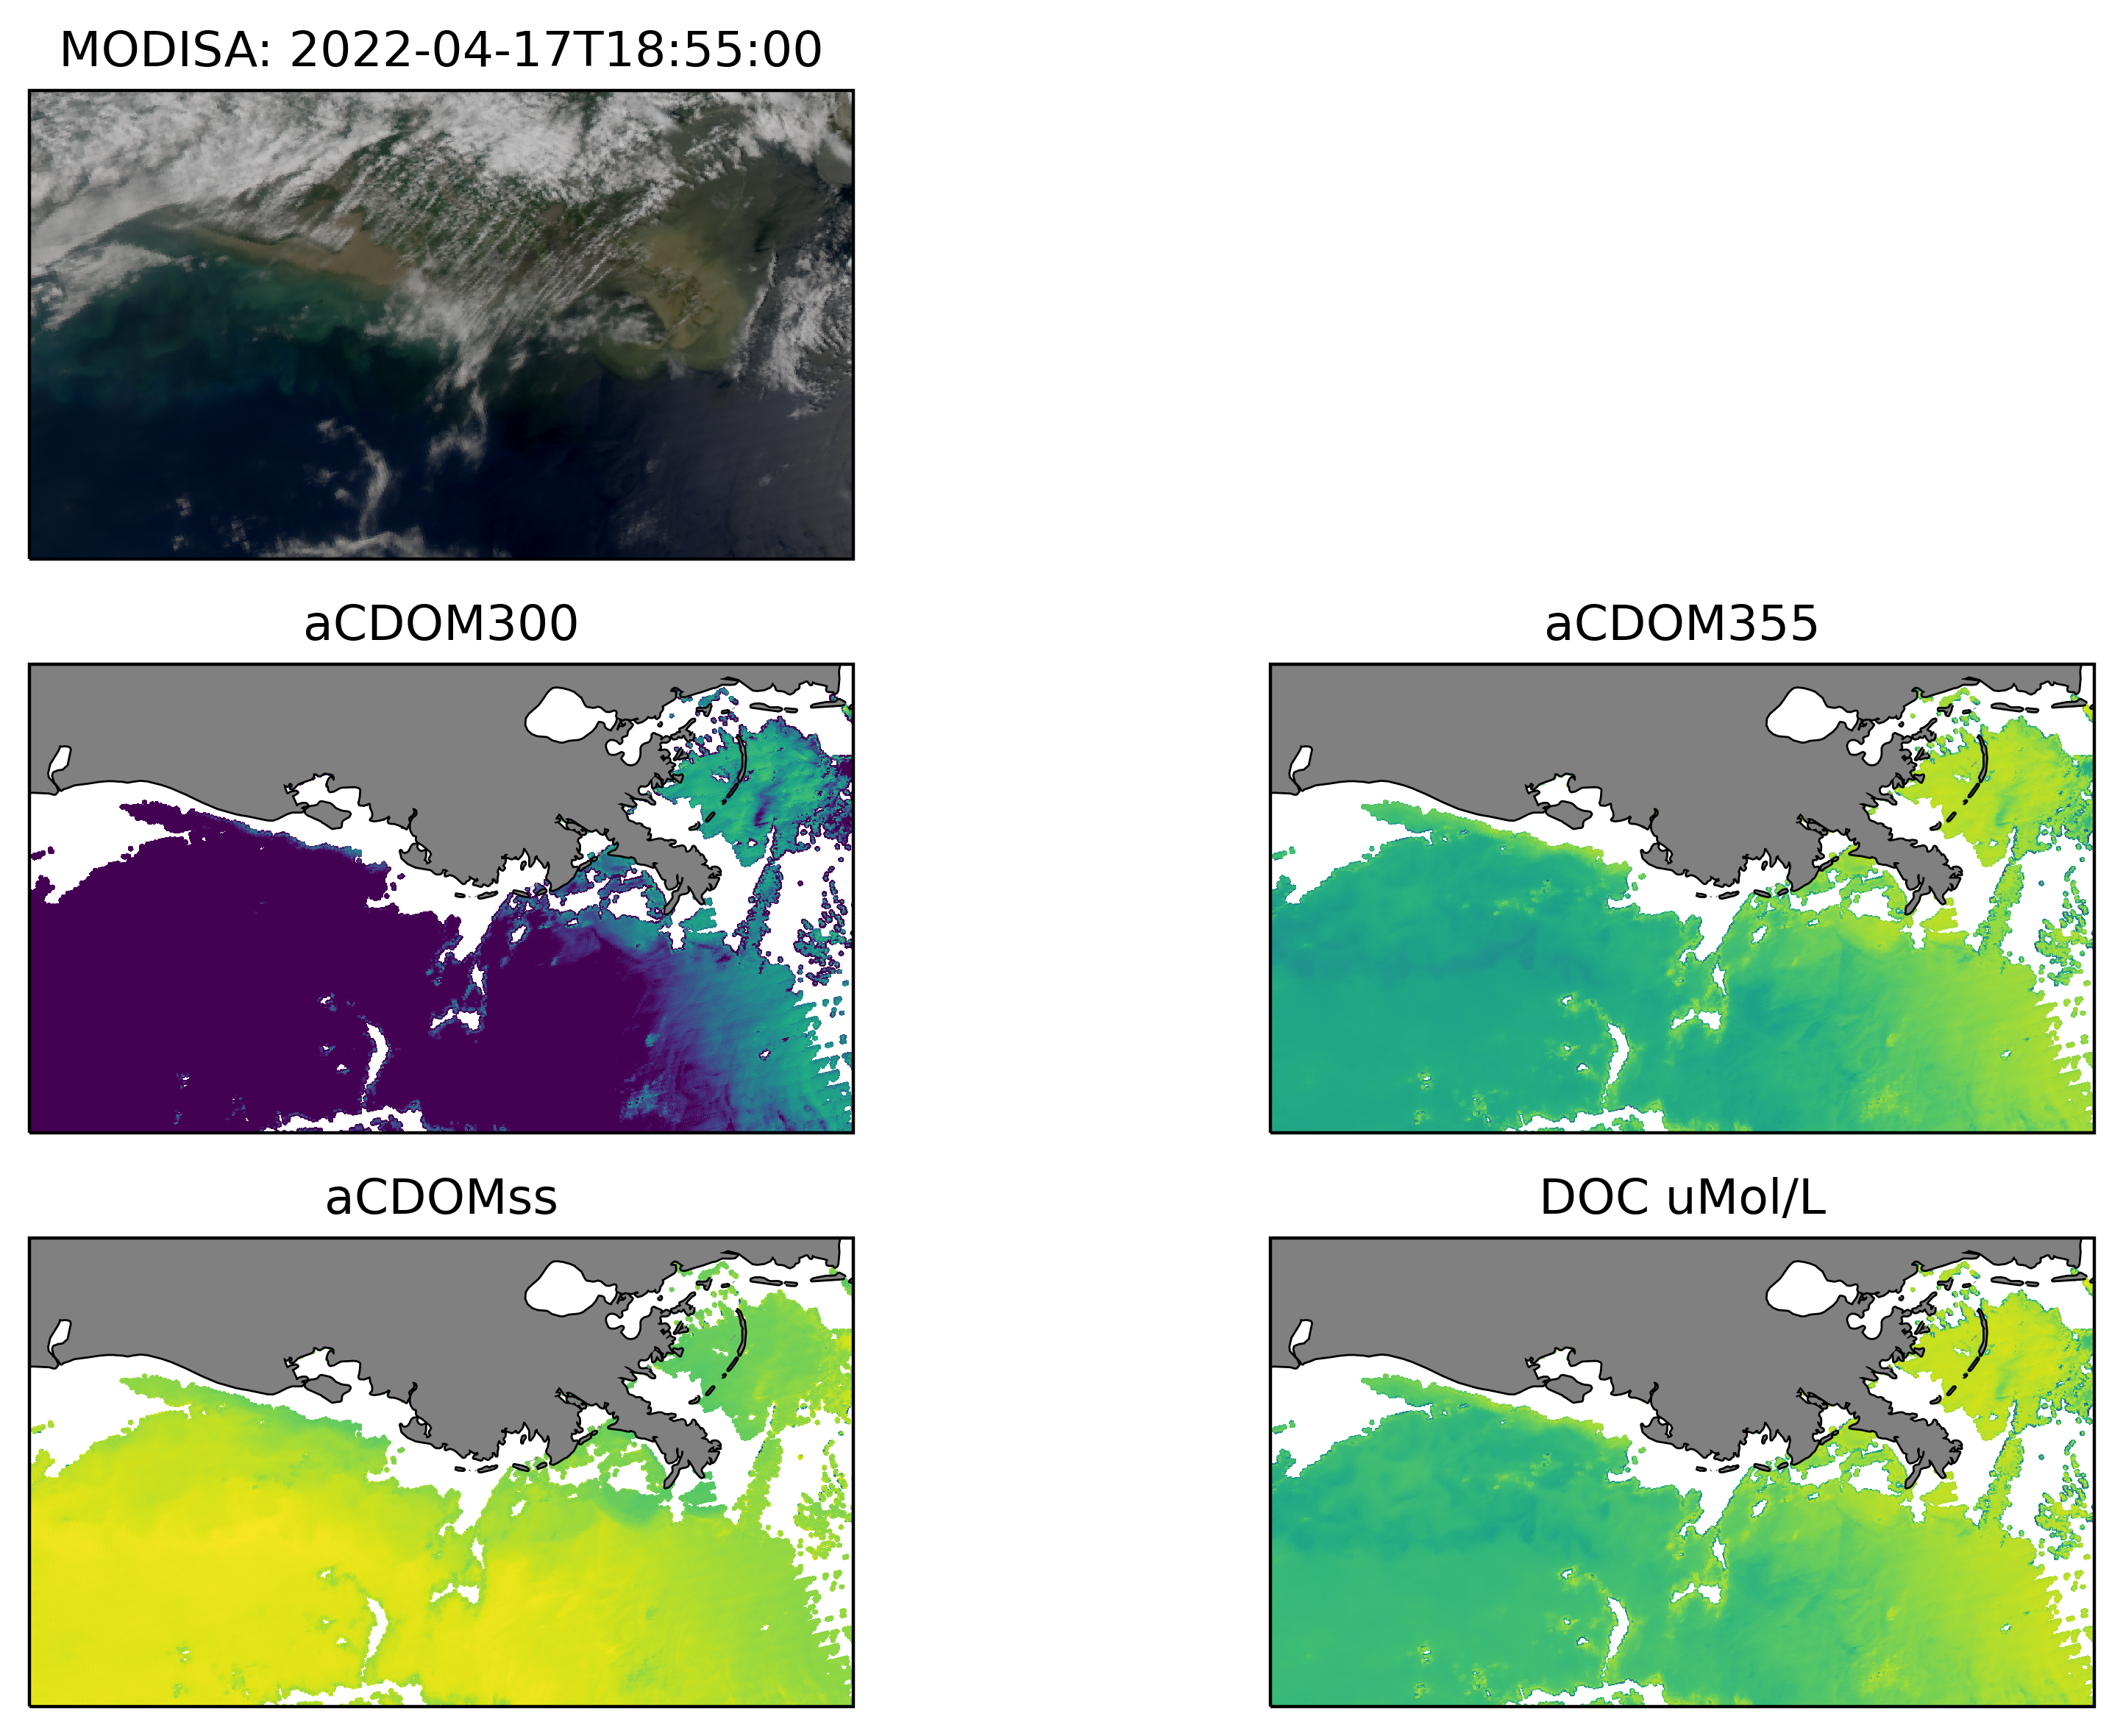

In [7]:
#HERE WE CALCUTE CDOM WITH THE ALGORITHUM WITH 
#Coa et al. 2018
i=0
dayfiles = glob(base+swats[i]+'*')
print(dayfiles)
extent=[-94, 27.5, -88, 30.5]
res = '10m'

#load scene
scn = Scene(dayfiles, reader='modis_l1b')
scn.load(['10','4', '11','9','13lo'])
scn.load(['true_color'])

#reproject
my_area = create_area_def('my_area', {'proj': 'lcc', 'lon_0': -91., 'lat_0': 29.5, 'lat_1': 29.5, 'lat_2': 29.5},
                          width=1500, height=750,
                          area_extent=extent, units='degrees')
new_scn = scn.resample(my_area)

#generate RGB from true color
rgb = get_enhanced_image(new_scn['true_color'])

Rss443 = np.log(new_scn['9'])
Rss448 = np.log(new_scn['10'])
Rss531 = np.log(new_scn['11'])
Rss555 = np.log(new_scn['4'])
Rss667 = np.log(new_scn['13lo'])

#calculate aCDOM 300
aCDOM300 = (-0.0206*Rss443) + (-0.6128*Rss448) + (-0.0070*Rss531) + (-0.4944*Rss555) + (0.9362*Rss667) + (.9666)
aCDOM300 = aCDOM300.compute()

#calculate aCDOM 355
aCDOM355 = (0.0376*Rss443) + (-0.8714*Rss448) +(-0.0352*Rss531) + (-0.2739*Rss555) + (0.9591*Rss667) + (-0.1071)
aCDOM355 = aCDOM355.compute()

#calculate aCDOM SS 275-295
aCDOMss = (-0.0537*Rss443) + (0.2689*Rss448) + (0.1017*Rss531) + (-0.2097*Rss555) + (-0.0893*Rss667) + (-3.6853)
aCDOMss = aCDOMss.compute()

#calculate DOC
#DOC = aCDOM300 / ((np.exp(-15.05-(33.95*aCDOMss)))+(np.exp(-1.502-(104.3*aCDOMss)))) 
TERM1 = (-15.05-(33.95*aCDOMss))
TERM2 = (-1.502-(04.3*aCDOMss))
# np.logaddexp Calculates log(exp(x1) + exp(x2))
TERM = np.logaddexp(TERM1, TERM2)
DOC = aCDOM300/(TERM) 
DOC = DOC.compute()

#extract projection and lon lat from products
crs = new_scn['true_color'].attrs['area'].to_cartopy_crs()
lons, lats = new_scn['true_color'].attrs['area'].get_lonlats()

#set up figure size and resolution
fig =  plt.figure(figsize=(9, 6), dpi=400)

# true color
ax1 = plt.subplot(3, 2, 1, projection=crs)
rgb.data.plot.imshow(rgb='bands', transform=crs, ax=ax1)
ax1.set_title('MODISA: %s' % new_scn.start_time.isoformat())

# aCDOM 300
trim = aCDOM300.max().values
ax3 = plt.subplot(3, 2, 3, projection=crs)
ax3.coastlines(res)
ax3.pcolormesh(lons, lats, aCDOM300.where(aCDOM300<=trim), transform=ccrs.PlateCarree(),
              vmin=.0, vmax=.3)
ax3.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                            name='land', facecolor='grey',
                                            scale=res))
ax3.set_title('aCDOM300')

# aCDOM 355
trim = aCDOM355.max().values
ax4 = plt.subplot(3, 2, 4, projection=crs)
ax4.coastlines(res)
ax4.pcolormesh(lons, lats, aCDOM355.where(aCDOM355<=trim), transform=ccrs.PlateCarree())
ax4.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                            name='land', facecolor='grey',
                                            scale=res))
ax4.set_title('aCDOM355')

# aCDOMss
trim = aCDOMss.max().values
ax5 = plt.subplot(3, 2, 5, projection=crs)
ax5.coastlines(res)
ax5.pcolormesh(lons, lats, aCDOMss.where(aCDOMss<=trim), transform=ccrs.PlateCarree())
ax5.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                            name='land', facecolor='grey',
                                            scale=res))
ax5.set_title('aCDOMss')

# DOC 
trim = DOC.max().values
ax6 = plt.subplot(3, 2, 6, projection=crs)
ax6.coastlines(res)
ax6.pcolormesh(lons, lats, DOC.where(DOC<=trim), transform=ccrs.PlateCarree())
ax6.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                            name='land', facecolor='grey',
                                            scale=res))
ax6.set_title('DOC uMol/L')

#optimize spacing between plots
fig.tight_layout()
#save
#fig.savefig('../outputs/Coa.png')